In [ ]:
import numpy as np
import torch
import torchvision as tv

from vocab import Vocabulary
import data
from data import CocoDataset
from data import get_test_loader

import os
import pickle
import time
import itertools

import PIL
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%pylab inline

In [2]:
imgbasepath = "data/coco/images/val2014/"
logpath = 'failure_log.pth'
faillog = torch.load(logpath)
fail_ids_t = faillog['fail_ids_t']
fail_ids_i = faillog['fail_ids_i']
id2path = torch.load("id2path.pth")
id2caption = torch.load("id2caption.pth")
embeddings = torch.load("embeddings.pth")
img_embs = embeddings['img_embs']
cap_embs = embeddings['cap_embs']

In [4]:
# load model and options
batch_size = 32
split = "test"
datapath = "data/"
modelpath = "runs/coco_vse++_resnet_restval_finetune/model_best.pth.tar"
checkpoint = torch.load(modelpath, map_location=lambda storage, loc: storage)
opt = checkpoint['opt']
opt.data_path = datapath
with open(os.path.join(opt.vocab_path,'%s_vocab.pkl' % opt.data_name), 'rb') as f:
    vocab = pickle.load(f)
opt.vocab_size = len(vocab)

class SimpleCocoDataset(CocoDataset):
    def __getitem__(self, index):
        if index < self.bp:
            coco = self.coco[0]
            root = self.root[0]
        else:
            coco = self.coco[1]
            root = self.root[1]
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']
        return index, caption, path

dpath = os.path.join(opt.data_path, opt.data_name)
roots, ids = data.get_paths(dpath, opt.data_name, opt.use_restval)
root = roots[split]['img']
json = roots[split]['cap']
ids = ids[split]
transform = None
dataset = SimpleCocoDataset(root=root,
                          json=json,
                          vocab=vocab,
                          transform=transform, ids=ids)
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          pin_memory=False,
                                          num_workers=4)

id2caption = {}
id2path = {}
for i, (indexes, captions, paths) in enumerate(data_loader):
    for idx, caption, path in zip(indexes, captions, paths):
        id2caption[idx] = caption
        id2path[idx] = path
    if i % 50 == 0:
        print("{} of {} processed".format(str(i), str(len(data_loader))))
torch.save(id2caption, "id2caption.pth")
torch.save(id2path, "id2path.pth")

loading annotations into memory...
Done (t=0.95s)
creating index...
index created!
0 of 782 processed
50 of 782 processed
100 of 782 processed
150 of 782 processed
200 of 782 processed
250 of 782 processed
300 of 782 processed
350 of 782 processed
400 of 782 processed
450 of 782 processed
500 of 782 processed
550 of 782 processed
600 of 782 processed
650 of 782 processed
700 of 782 processed
750 of 782 processed


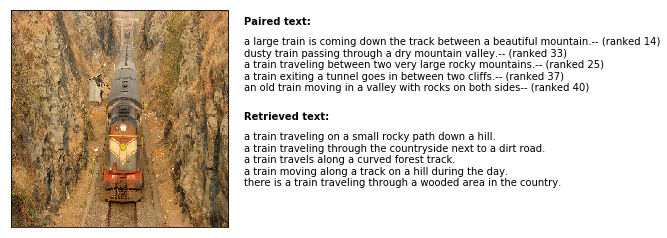

In [262]:
# evaluate visually mistakes made by the model
randidx = np.random.choice(fail_ids_t)

d = np.dot(img_embs[randidx:randidx+1], cap_embs.T).flatten()
inds = numpy.argsort(d)[::-1]
top5 = inds[0:5]
retrievedlist = map(lambda x: id2caption[x].lower(), top5)
for i, top in enumerate(top5):
    if top in range(randidx, randidx+5):
        retrievedlist[i] = retrievedlist[i] + " ( * )"
retrievedtext = "\n".join(retrievedlist)

pairedlist = map(lambda x: id2caption[x].lower(), range(randidx, randidx+5))
for i, paired in enumerate(range(randidx, randidx+5)):
    rank = np.argwhere(inds == paired)[0][0] + 1
    pairedlist[i] = pairedlist[i] + "-- (ranked {})".format(str(rank))
text = "\n".join(pairedlist)

image = Image.open(imgbasepath+id2path[randidx]).resize((300,300))
frame = plt.gca()
frame.get_xaxis().set_visible(False)
frame.get_yaxis().set_visible(False)
plt.imshow(image)
figtext(0.8, 0.83, "Paired text:", weight="bold")
figtext(0.8, 0.6, text)
figtext(0.8, 0.5, "Retrieved text:", weight="bold")
figtext(0.8, 0.27, retrievedtext)